In [109]:
# Import Modules
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC


In [78]:
# Collect and prepare the stock data

In [79]:
# use QQQ as the ticker
ticker = yf.Ticker("QQQ")

In [80]:
# Dataset period
ticker_df = ticker.history(start="2012-01-01", end="2021-12-31")

display(ticker_df.head())
display(ticker_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03,51.671298,51.925522,51.526026,51.662220,39514100,0.0,0
2012-01-04,51.580506,51.952764,51.353519,51.880127,29403400,0.0,0
2012-01-05,51.771180,52.352266,51.571431,52.306870,41260600,0.0,0
2012-01-06,52.315944,52.606487,52.116198,52.488457,46325200,0.0,0
2012-01-09,52.624639,52.642799,52.143428,52.315937,39195500,0.0,0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-23,394.309998,398.429993,394.140015,396.920013,29595500,0.0,0
2021-12-27,398.250000,403.480011,398.220001,403.480011,32820700,0.0,0
2021-12-28,404.399994,404.579987,400.709991,401.609985,33113700,0.0,0
2021-12-29,401.750000,403.049988,399.109985,401.549988,32248500,0.0,0
2021-12-30,401.329987,403.570007,399.750000,400.350006,23850100,0.0,0


In [82]:
# Create the Features Set

In [93]:
# Filter the date index and close columns
signals_df = ticker_df.loc[:, ["Close"]]
# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()
# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()
# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2012-01-04,51.880127,0.004218
2012-01-05,52.306870,0.008226
2012-01-06,52.488457,0.003472
2012-01-09,52.315937,-0.003287
2012-01-10,52.697281,0.007289


,Close,Actual Returns
Date,,
2021-12-23,396.920013,0.007539
2021-12-27,403.480011,0.016527
2021-12-28,401.609985,-0.004635
2021-12-29,401.549988,-0.000149
2021-12-30,400.350006,-0.002988


In [94]:
# Set the short window and long window
short_window = 7
long_window = 25

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2012-02-08,56.710407,0.005311,55.955517,54.228084
2012-02-09,57.118977,0.007204,56.264217,54.437638
2012-02-10,56.719501,-0.006994,56.452293,54.614144
2012-02-13,57.246094,0.009284,56.690953,54.804449
2012-02-14,57.391365,0.002538,56.841413,55.007466


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396
2021-12-27,403.480011,0.016527,390.716513,392.930095
2021-12-28,401.609985,-0.004635,392.897003,392.855508
2021-12-29,401.549988,-0.000149,395.344286,392.965881
2021-12-30,400.350006,-0.002988,398.152858,393.100962


In [95]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2012-02-08,56.710407,0.005311,55.955517,54.228084,1.0
2012-02-09,57.118977,0.007204,56.264217,54.437638,1.0
2012-02-10,56.719501,-0.006994,56.452293,54.614144,-1.0
2012-02-13,57.246094,0.009284,56.690953,54.804449,1.0
2012-02-14,57.391365,0.002538,56.841413,55.007466,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396,1.0
2021-12-27,403.480011,0.016527,390.716513,392.930095,1.0
2021-12-28,401.609985,-0.004635,392.897003,392.855508,-1.0
2021-12-29,401.549988,-0.000149,395.344286,392.965881,-1.0
2021-12-30,400.350006,-0.002988,398.152858,393.100962,-1.0


In [96]:
signals_df['Signal'].value_counts()

 1.0    1421
-1.0    1070
Name: Signal, dtype: int64

In [97]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2012-02-08,56.710407,0.005311,55.955517,54.228084,1.0,NaN
2012-02-09,57.118977,0.007204,56.264217,54.437638,1.0,0.007204
2012-02-10,56.719501,-0.006994,56.452293,54.614144,-1.0,-0.006994
2012-02-13,57.246094,0.009284,56.690953,54.804449,1.0,-0.009284
2012-02-14,57.391365,0.002538,56.841413,55.007466,1.0,0.002538


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396,1.0,0.007539
2021-12-27,403.480011,0.016527,390.716513,392.930095,1.0,0.016527
2021-12-28,401.609985,-0.004635,392.897003,392.855508,-1.0,-0.004635
2021-12-29,401.549988,-0.000149,395.344286,392.965881,-1.0,0.000149
2021-12-30,400.350006,-0.002988,398.152858,393.100962,-1.0,0.002988


<AxesSubplot:xlabel='Date'>

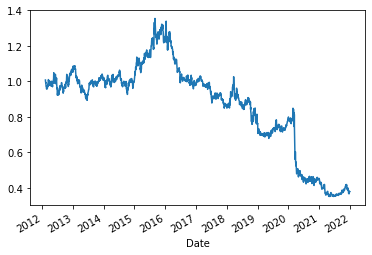

In [98]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [110]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna().copy()

# Review the DataFrame
display(X.head())
display(X.tail())

,SMA_Fast,SMA_Slow
Date,,
2012-02-09,55.955517,54.228084
2012-02-10,56.264217,54.437638
2012-02-13,56.452293,54.614144
2012-02-14,56.690953,54.804449
2012-02-15,56.841413,55.007466


,SMA_Fast,SMA_Slow
Date,,
2021-12-23,388.409132,392.848507
2021-12-27,389.725586,392.840396
2021-12-28,390.716513,392.930095
2021-12-29,392.897003,392.855508
2021-12-30,395.344286,392.965881


In [111]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    1421
-1.0    1070
Name: Signal, dtype: int64

In [112]:
# Select the start of the training period
training_begin = X.index.max() - DateOffset(months=30)

# Display the training begin date
print(training_begin)

2019-06-30 00:00:00


In [113]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.max()  - DateOffset(months=3)

# Display the training end date
print(training_end)

2021-09-30 00:00:00


In [114]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

,SMA_Fast,SMA_Slow
Date,,
2019-07-01,184.236736,178.801691
2019-07-02,184.353110,179.254721
2019-07-03,184.614393,179.763666
2019-07-05,185.076144,180.386401
2019-07-08,185.937703,180.964657


,SMA_Fast,SMA_Slow
Date,,
2021-09-24,371.431074,374.389192
2021-09-27,370.817383,374.779615
2021-09-28,369.741468,374.900552
2021-09-29,367.808794,374.383345
2021-09-30,366.892822,373.797079


In [115]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
Date,,
2021-10-01,365.724317,373.140920
2021-10-04,364.384600,372.668420
2021-10-05,361.479736,371.749452
2021-10-06,359.204075,370.852242
2021-10-07,357.680307,370.058887


,SMA_Fast,SMA_Slow
Date,,
2021-12-23,388.409132,392.848507
2021-12-27,389.725586,392.840396
2021-12-28,390.716513,392.930095
2021-12-29,392.897003,392.855508
2021-12-30,395.344286,392.965881


In [116]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [117]:
# From SVM, instantiate SVC classifier model instance
# Classification report on Train is not helpful
from sklearn.svm import SVC
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
from sklearn.metrics import classification_report
svm_training_report = classification_report(y_train, svm_pred)
print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       230
         1.0       0.60      1.00      0.75       339

    accuracy                           0.60       569
   macro avg       0.30      0.50      0.37       569
weighted avg       0.35      0.60      0.44       569



/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [118]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = svm_model.predict(X_test_scaled)

# Print the classification report
print (classification_report(y_test, svm_testing_report))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        25
         1.0       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbeeson/opt/anaconda3/envs/unsupp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [119]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_testing_report

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']

predictions_df['Trading Algorithm Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']


# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-10-01,1.0,0.006202,-0.006202,0.006202
2021-10-04,1.0,-0.020989,-0.020989,-0.020989
2021-10-05,1.0,0.013499,-0.013499,0.013499
2021-10-06,1.0,0.006408,0.006408,0.006408
2021-10-07,1.0,0.009175,0.009175,0.009175


,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-12-23,1.0,0.007539,0.007539,0.007539
2021-12-27,1.0,0.016527,0.016527,0.016527
2021-12-28,1.0,-0.004635,-0.004635,-0.004635
2021-12-29,1.0,-0.000149,0.000149,-0.000149
2021-12-30,1.0,-0.002988,0.002988,-0.002988


<AxesSubplot:xlabel='Date'>

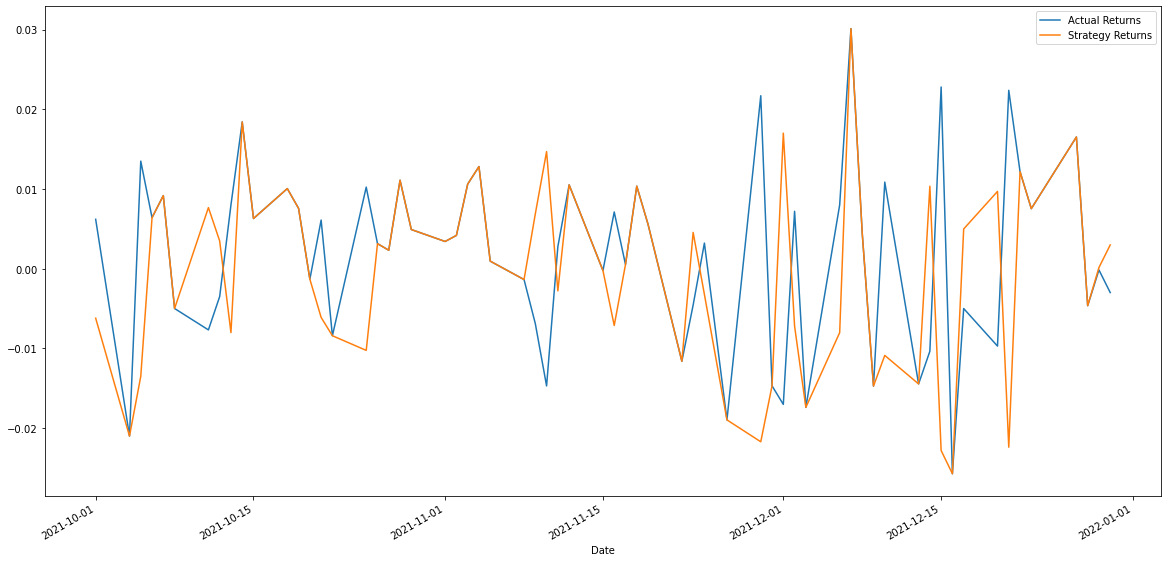

In [120]:
# Plot the actual returns versus the strategy returns
fig, ax = plt.subplots(figsize=(20, 10))
predictions_df[['Actual Returns', 'Strategy Returns']].plot(ax=ax)

<AxesSubplot:title={'center':'SVC Algo'}, xlabel='Date'>

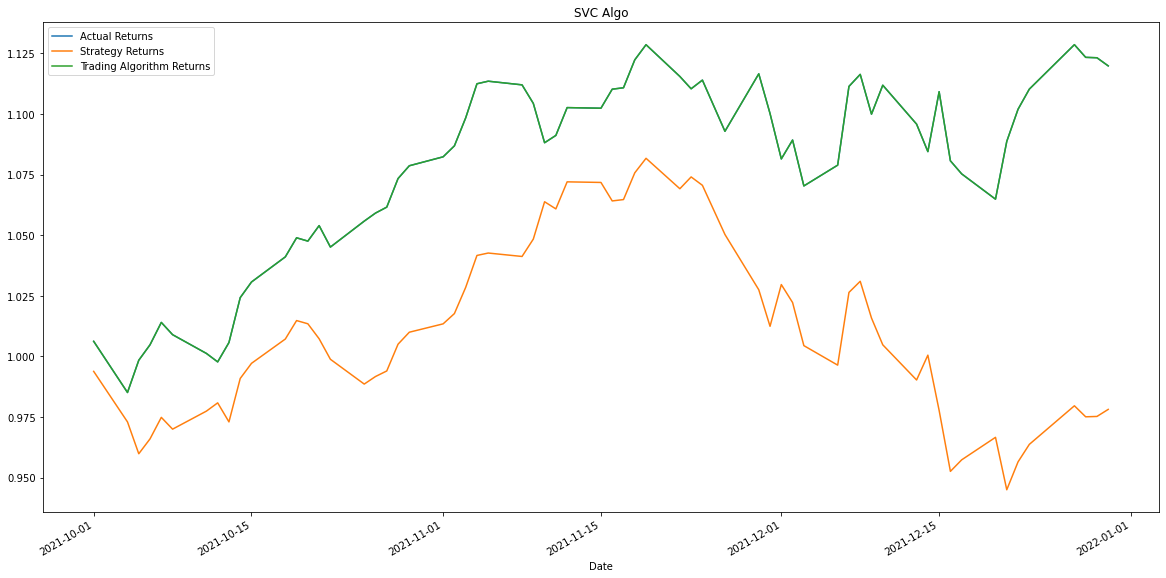

In [121]:
# Calculate and plot the cumulative returns for the `Actual Returns`,`Strategy Returns` and the `Trading Algorithm Returns`
fig, ax = plt.subplots(figsize=(20, 10))
(1 + predictions_df[['Actual Returns', 'Strategy Returns','Trading Algorithm Returns']]).cumprod().plot(
    ax=ax,title='SVC Algo')